In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


In [ ]:
def load_and_preprocess_image(file_path, target_size=(128, 128)):
    """
    이미지를 로드하고 전처리합니다.

    Parameters:
    - file_path: 이미지 파일 경로
    - target_size: 이미지 크기 (width, height)

    Returns:
    - image: 전처리된 이미지 (NumPy 배열, shape: (height, width, 1))
    """
    with Image.open(file_path) as img:
        img = img.convert('L')  # 그레이스케일 변환 (컬러 이미지인 경우 'RGB'로 변경 가능)
        img = img.resize(target_size, Image.NEAREST)
        img = np.array(img).astype('float32') / 255.0  # 정규화
        img = np.expand_dims(img, axis=-1)  # 채널 차원 추가
    return img

In [ ]:
def create_dataset(x_dir, y_dir, target_size=(128, 128)):
    """
    x 폴더와 y 폴더에서 이미지를 로드하고 (입력, 타겟) 데이터셋을 생성합니다.

    Parameters:
    - x_dir: 입력 이미지 폴더 경로
    - y_dir: 타겟 이미지 폴더 경로
    - target_size: 이미지 크기 (width, height)

    Returns:
    - X: 입력 이미지들 (NumPy 배열, shape: (num_samples, height, width, 1))
    - Y: 타겟 이미지들 (NumPy 배열, shape: (num_samples, height, width, 1))
    """
    X = []
    Y = []

    # x 폴더의 모든 파일 이름을 가져옵니다.
    x_files = [f for f in os.listdir(x_dir) if f.endswith('.png')]

    for x_file in x_files:
        # y 폴더에서 대응되는 y 파일 이름 생성
        y_file = x_file.replace('_0.png', '_7.png')
        x_path = os.path.join(x_dir, x_file)
        y_path = os.path.join(y_dir, y_file)

        # y 파일이 존재하는 경우에만 추가
        if os.path.exists(y_path):
            x_image = load_and_preprocess_image(x_path, target_size)
            y_image = load_and_preprocess_image(y_path, target_size)
            X.append(x_image)
            Y.append(y_image)
        else:
            print(f'Warning: {y_file} does not exist in {y_dir}. Skipping.')

    X = np.array(X)
    Y = np.array(Y)

    print(f'Total samples: {X.shape[0]}')
    return X, Y

In [ ]:
# 디렉토리 경로 설정
x_directory = 'x_0frame'  # 실제 x 폴더 경로로 변경
y_directory = 'y_7frame'  # 실제 y 폴더 경로로 변경

# 데이터 로드
X, Y = create_dataset(x_directory, y_directory, target_size=(128, 128))

# 데이터 분할 (훈련: 80%, 검증: 20%)
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')


Total samples: 25
Training samples: 20
Validation samples: 5


In [ ]:
def build_frame_prediction_model(input_shape=(128, 128, 1)):
    """
    프레임 예측을 위한 간단한 CNN 모델을 구축합니다.

    Parameters:
    - input_shape: 입력 이미지 형태 (height, width, channels)

    Returns:
    - model: Keras 모델
    """
    model = models.Sequential(name='Frame_Prediction_Model')

    # 인코더
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))  # 64x64x32

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))  # 32x32x64

    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))  # 16x16x128

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    # 디코더
    model.add(layers.Dense(16*16*128, activation='relu'))
    model.add(layers.Reshape((16, 16, 128)))  # 16x16x128

    model.add(layers.Conv2DTranspose(128, (3,3), strides=2, activation='relu', padding='same'))  # 32x32x128
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same'))  # 64x64x64
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same'))  # 128x128x32
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(1, (3,3), activation='sigmoid', padding='same'))  # 128x128x1

    return model


In [ ]:
def compile_model(model, learning_rate=1e-4):
    """
    모델을 컴파일합니다.

    Parameters:
    - model: Keras 모델
    - learning_rate: 학습률

    Returns:
    - model: 컴파일된 Keras 모델
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [ ]:
# 모델 구축
input_shape = (128, 128, 1)  # 그레이스케일 이미지
model = build_frame_prediction_model(input_shape)

# 모델 컴파일
model = compile_model(model, learning_rate=1e-4)

# 모델 요약
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Frame_Prediction_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32768)               │       8,421,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,4

 Total params: 17,144,833 (65.40 MB)

 Trainable params: 17,143,937 (65.40 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# # 데이터 증강 설정
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2]
# )

In [ ]:
# def train_generator(X, Y, batch_size=32):
#     """
#     데이터 증강을 적용한 훈련 데이터 제너레이터.

#     Parameters:
#     - X: 입력 이미지들
#     - Y: 타겟 이미지들
#     - batch_size: 배치 크기

#     Returns:
#     - generator: 증강된 데이터 제너레이터
#     """
#     while True:
#         for i in range(0, len(X), batch_size):
#             X_batch = X[i:i+batch_size]
#             Y_batch = Y[i:i+batch_size]
#             # 입력 데이터 증강
#             X_augmented = np.array([datagen.random_transform(x) for x in X_batch])
#             yield X_augmented, Y_batch


In [ ]:
# # 콜백 설정
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint(
#     'best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )


In [ ]:
# 하이퍼파라미터 설정
epochs = 1000
batch_size = 32

# 스텝 수 계산
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# 모델 훈련
history = model.fit(
    # train_generator(X_train, Y_train, batch_size),
    X_train, Y_train,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    # callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1037 - mae: 0.2639 - val_loss: 0.1243 - val_mae: 0.3503
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1036 - mae: 0.2638 - val_loss: 0.1230 - val_mae: 0.3485
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1036 - mae: 0.2639 - val_loss: 0.1218 - val_mae: 0.3468
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1033 - mae: 0.2634 - val_loss: 0.1206 - val_mae: 0.3451
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1019 - mae: 0.2605 - val_loss: 0.1195 - val_mae: 0.3434
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1006 - mae: 0.2578 - val_loss: 0.1182 - val_mae: 0.3416
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1009 - mae: 0.2582 - val_loss: 0.1170 - val_mae: 0.3398
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0995 - mae: 0.2553 - val_loss: 0.1158 - val_mae: 0.3381
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.099

In [ ]:
def predict_frame(model, input_image):
    """
    모델을 사용하여 프레임을 예측합니다.

    Parameters:
    - model: 훈련된 Keras 모델
    - input_image: 입력 이미지 (NumPy 배열, shape: (1, height, width, 1))

    Returns:
    - predicted_image: 예측된 이미지 (NumPy 배열, shape: (height, width, 1))
    """
    predicted = model.predict(input_image)
    predicted = predicted[0]  # 배치 차원 제거
    predicted = np.clip(predicted, 0, 1)  # 값 범위 조정
    return predicted


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


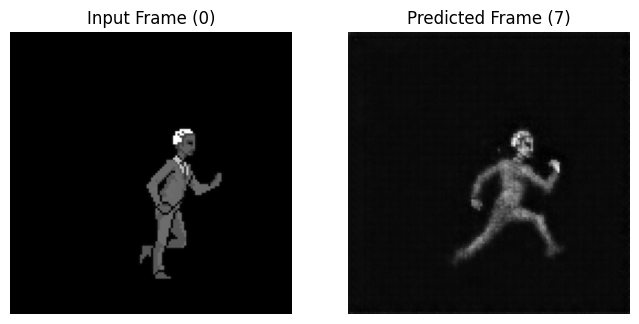

In [20]:
# 테스트할 입력 이미지 경로 설정
test_input_path = 'frame_50_0.png'  # 실제 테스트 입력 이미지 경로로 변경

# 입력 이미지 로드 및 전처리
test_input_image = load_and_preprocess_image(test_input_path, target_size=(128, 128))
test_input_image = np.expand_dims(test_input_image, axis=0)  # 배치 차원 추가

# 프레임 예측
predicted_image = predict_frame(model, test_input_image)

# 원본 입력 이미지와 예측된 이미지를 시각화
plt.figure(figsize=(8,4))

# 원본 입력 이미지
plt.subplot(1,2,1)
plt.title('Input Frame (0)')
plt.imshow(test_input_image[0, :, :, 0], cmap='gray')
plt.axis('off')

# 예측된 7번째 프레임
plt.subplot(1,2,2)
plt.title('Predicted Frame (7)')
plt.imshow(predicted_image[:, :, 0], cmap='gray')
plt.axis('off')

plt.show()
